## Create simple GPT architecture

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from numpy.core.shape_base import block
from math import sqrt
import random
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset

In [3]:
##utils

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def tok_k_logits(logits, k):
    v, ix = torch.topk(logits,k)
    out = logits.clone()
    out[out < v[:,[-1]]] = -float('inf')
    return out

@torch.no_grad()
def sample_context(model, x, steps, temperature=1.0, sample=True, top_k=10):
    block_size = model.block_size
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:]
        _, logits = model(x_cond)

        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            logits = tok_k_logits(logits, top_k)

        probs = F.softmax(logits, dim=-1)

        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _,ix = torch.topk(probs, k=1, dim=-1)
        x = torch.cat((x,ix),dim=1)
    return x

In [4]:
class GPTconfig:
    resid_drop = 0.1
    attn_drop = 0.1
    pos_drop = 0.1
    block_size = 512
    vocab_size = 65

    def __init__(self, **kwargs) -> None:
        for k,v in kwargs.items():
            setattr(self,k,v)

class GPT1config(GPTconfig):
    n_heads = 12
    num_layers = 12
    embd_size = 768

class GPT2config(GPTconfig):
    n_heads = 12
    num_layers = 12
    embd_size = 768
    vocab_size = 50257
    block_size = 1024

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, config: GPTconfig) -> None:
        super(SelfAttention, self).__init__()

        self.embd_size = config.embd_size
        self.n_heads = config.n_heads

        assert self.embd_size % self.n_heads == 0, f"d_model({config.embd_size}) must be divisible by n_heads({config.n_heads})."

        self.key = nn.Linear(config.embd_size, config.embd_size)
        self.query = nn.Linear(config.embd_size, config.embd_size)
        self.value = nn.Linear(config.embd_size, config.embd_size)

        self.projection = nn.Linear(config.embd_size, config.embd_size)

        self.attn_drop = nn.Dropout(config.attn_drop)
        self.resid_drop = nn.Dropout(config.resid_drop)

        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size)).view(1,1,config.block_size, config.block_size))


    def forward(self, x) -> torch.Tensor:
        B,T,C = x.size()

        # shape of k,q,v would be (batch_size, n_heads, block_size, hs)
        k = self.key(x).view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)
        q = self.query(x).view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)
        v = self.value(x).view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)

        # (batch_size, n_heads, block_size, hs) x (batch_size, n_heads, hs, block_size) -> (batch_size, n_heads, block_size, block_size)
        attn = (q @ k.transpose(2,3)) / sqrt(k.size(-1))
        attn = attn.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        # (batch_size, n_heads, block_size, block_size) x (batch_size, n_heads, block_size, hs) -> (batch_size, n_heads, block_size, hs)
        y = attn @ v
        y = y.transpose(1,2).contiguous().view(B, T, C)

        y = self.projection(y)
        y = self.resid_drop(y)

        return y

class PointWiseFeedForward(nn.Module):

    def __init__(self, config: GPTconfig) -> None:
        super().__init__()

        self.mlp = nn.Sequential(
                                nn.Linear(config.embd_size, config.embd_size * 4),
                                nn.GELU(),
                                nn.Linear(config.embd_size * 4, config.embd_size),
                                nn.Dropout(config.resid_drop)
                                )

    def forward(self, x):
        return self.mlp(x)

In [6]:
class Block(nn.Module):

    def __init__(self, config: GPTconfig) -> None:
        super().__init__()

        self.attn = SelfAttention(config)

        self.ln1 = nn.LayerNorm(config.embd_size)
        self.ln2 = nn.LayerNorm(config.embd_size)

        self.mlp = PointWiseFeedForward(config)

    def forward(self, x) -> torch.Tensor:
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config: GPTconfig) -> None:
        super().__init__()

        self.tok_embd = nn.Embedding(config.vocab_size,config.embd_size)
        self.pos_embd = nn.Parameter(torch.zeros(1,config.block_size, config.embd_size))
        self.embd_drop = nn.Dropout(config.pos_drop)

        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.num_layers)])

        self.ln = nn.LayerNorm(config.embd_size, config.embd_size)
        self.head = nn.Linear(config.embd_size, config.vocab_size)

        self.apply(self._init_weights)
        self.block_size = config.block_size

        print("Number of Trainable Parameters : ", sum([p.numel() for p in self.parameters()]))

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(0,0.02)
            if isinstance(module, (nn.Linear)) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, (nn.LayerNorm)):
            module.weight.data.fill_(1.0)
            module.bias.data.zero_()

    def forward(self, x, targets=None):
        B, T = x.size()

        tok_embd = self.tok_embd(x)
        pos_embd = self.pos_embd[:, :T, :]

        embd = self.embd_drop(tok_embd + pos_embd)
        out = self.blocks(embd)
        out = self.ln(out)
        logits = self.head(out)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return loss, logits

    def configure_optimizer(self, config) -> torch.optim.AdamW:
        decay = set()
        no_decay = set()

        for pn, p in self.named_parameters():
            if pn.endswith('bias'):
                no_decay.add(pn)
            elif pn.endswith('weight') and (".ln" in pn or ".tok_embd" in pn):
                no_decay.add(pn)
            else:
                decay.add(pn)

        params = {pn:p for pn,p in self.named_parameters()}

        optim_groups = [
            {"params": [params[pn] for pn in sorted(list(decay))], "weight_decay": config.weight_decay},
            {"params": [params[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=config.lr, betas=config.betas, eps=config.epsilon)
        return optimizer

In [14]:
## trainer config

class TrainingConfig:
    max_epochs = 100
    lr = 3e-4
    betas = (0.9,0.95)
    weight_decay = 0.1
    epsilon = 10e-8
    batch_size = 64
    grad_norm_clip = 1.0
    lr_decay = True
    num_workers = 0
    warmup_tokens = 375e6
    final_tokens = 260e9
    shuffle = True
    pin_memory = True
    device = "cuda"
    ckpt_path = "./transformers.pt"

    def __init__(self, **kwargs) -> None:
        for k,v in kwargs.items():
            setattr(self,k,v)

class Trainer:
    def __init__(self, model, train_set, test_set, configs) -> None:
        self.model = model
        self.train_set = train_set
        self.test_set = test_set
        self.configs = configs

        self.device = torch.device("cuda" if torch.cuda.is_available() and configs.device == "cuda" else "cpu")
        self.model = self.model.to(self.device)

        self.losses = {'train': [], 'test': []}
        self.fig, self.ax = plt.subplots(figsize=(8, 5))

    def train(self):
        model, config = self.model, self.configs
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        optimizer = raw_model.configure_optimizer(config)

        for epoch in range(config.max_epochs):
            train_loss = self.run_epoch('train', epoch, optimizer)
            if self.test_set is not None:
                test_loss = self.run_epoch('test', epoch, None)

            self.losses['train'].append(train_loss)
            if self.test_set:
                self.losses['test'].append(test_loss)

            self.update_plot(epoch)

            if config.ckpt_path and (self.test_set is None or test_loss < min(self.losses['test'])):
                self.save_checkpoint()

    def run_epoch(self, split, epoch, optimizer):
        is_train = split == "train"
        self.model.train() if is_train else self.model.eval()
        data = self.train_set if is_train else self.test_set
        loader = DataLoader(data, batch_size=self.configs.batch_size, 
                            num_workers=self.configs.num_workers, 
                            shuffle=is_train and self.configs.shuffle, 
                            pin_memory=self.configs.pin_memory)
        total_loss = 0
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            loss, _ = self.model(x, y)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.configs.grad_norm_clip)
                optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

    def update_plot(self, epoch):
        clear_output(wait=True)
        self.ax.clear()
        self.ax.plot(self.losses['train'], label='Training Loss')
        if self.test_set:
            self.ax.plot(self.losses['test'], label='Testing Loss')
        self.ax.set_title(f'Loss Over Epochs up to Epoch {epoch+1}')
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.ax.grid(True)
        display(self.fig)
        time.sleep(0.1)  # pause to ensure the plot updates visually in the notebook

    def save_checkpoint(self):
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        print(f"saving model at {self.configs.ckpt_path}.")
        torch.save(raw_model.state_dict(), self.configs.ckpt_path)

In [15]:
seed_all(42)

## Preapre data

In [16]:
class CharacterDataset(Dataset):
        def __init__(self, data, block_size):
            characters = sorted(list(set(data)))
            data_size, vocab_size = len(data), len(characters)

            print(f"Dataset has {data_size} characters. {vocab_size} of characters are unique.")

            # char to idx mapping and vice-versa
            self.stoi = {ch:i for i,ch in enumerate(characters)}
            self.itos = {i:ch for i,ch in enumerate(characters)}

            self.block_size = block_size
            self.vocab_size = vocab_size
            self.data_size = data_size
            self.data = data

        def __len__(self):
            return self.data_size - self.block_size

        def __getitem__(self, idx):
            # take a chunk of data from the given index from the dataset
            chunk = self.data[idx : idx + self.block_size + 1]

            data = [self.stoi[ch] for ch in chunk]

            # create x and y.
            # x will contain every but the last character in the chunk.
            # y will contain every but the first character in the chunk.

            x = torch.tensor(data[:-1], dtype=torch.long)
            y = torch.tensor(data[1:], dtype=torch.long)

            return x,y

In [ ]:
DATA_PATH = "/content/book.txt"
BLOCK_SIZE = 128 # spatial context of the transformer

In [ ]:
file = open(DATA_PATH, "r")
data = file.read(-1)

dataset = CharacterDataset(data = data, block_size = BLOCK_SIZE)

In [27]:
## visualize dataset

batch = dataset[0]
x, y = batch
x = x.tolist()
y = y.tolist()

for i in range(len(x)):
    x[i] = dataset.itos[x[i]]
    y[i] = dataset.itos[y[i]]

print(f"Training Data : \n\n{''.join(x)}")
print(f"\nTargets : \n\n{''.join(y)}")

Training Data : 

The Project Gutenberg eBook of War and Peace
    
This ebook is for the use of anyone anywhere in the United States and
most oth

Targets : 

he Project Gutenberg eBook of War and Peace
    
This ebook is for the use of anyone anywhere in the United States and
most othe


So let's clean our data manually from text, with not related with main book (authors comments, publisher information and etc)

In [10]:
DATA_PATH = "book_cleaned.txt"
BLOCK_SIZE = 128 # spatial context of the transformer

file = open(DATA_PATH, "r")

import codecs
file = codecs.open(DATA_PATH, "r", "utf-8" )
data = file.read()
file.close()

dataset = CharacterDataset(data = data, block_size = BLOCK_SIZE)

## visualize dataset

batch = dataset[0]
x, y = batch
x = x.tolist()
y = y.tolist()

for i in range(len(x)):
    x[i] = dataset.itos[x[i]]
    y[i] = dataset.itos[y[i]]

print(f"Training Data : \n\n{''.join(x)}")
print(f"\nTargets : \n\n{''.join(y)}")

Dataset has 3201672 characters. 104 of characters are unique.
Training Data : 

WAR AND PEACE


BOOK ONE: 1805





CHAPTER I

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes.

Targets : 

AR AND PEACE


BOOK ONE: 1805





CHAPTER I

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. 


## start training

In [17]:
gpt_config = GPTconfig(num_layers = 2,
                       n_heads = 12,
                       embd_size = 768,
                       vocab_size = dataset.vocab_size,
                       block_size = dataset.block_size
                      )

model = GPT(gpt_config)

Number of Trainable Parameters :  14435432


In [18]:
train_config = TrainingConfig(max_epochs = 3,
                              batch_size = 256,
                              lr_decay = True,
                              lr = 6e-4,
                              warmup_tokens = 512*20,
                              final_tokens = 2 * len(dataset) * dataset.block_size,
                              ckpt_path = "checkpoints/transformers.pt"
                             )

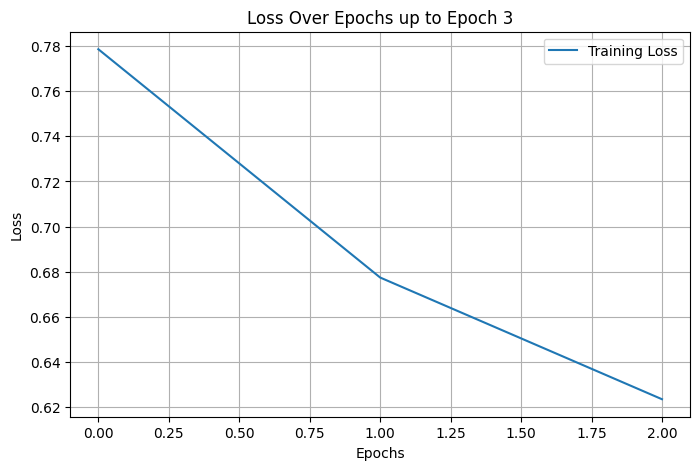

saving model at checkpoints/transformers.pt.


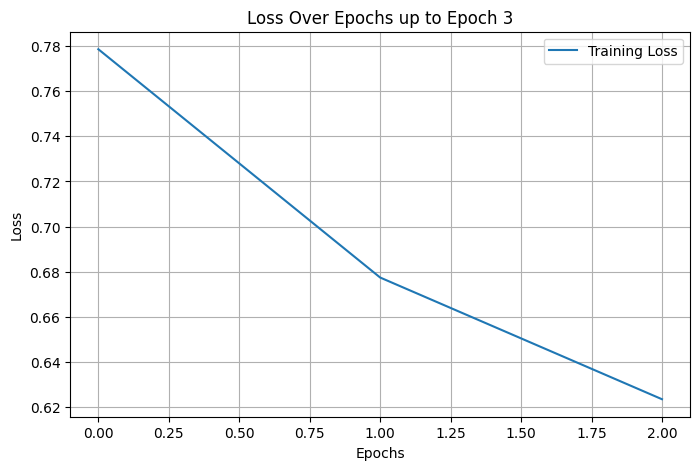

In [20]:
trainer = Trainer(model = model, train_set = dataset, test_set = None, configs = train_config)
trainer.train()

## Test generation

In [21]:
seed_context = "Andrei, what is the purpose?"
x = torch.tensor([dataset.stoi[s] for s in seed_context], dtype=torch.long, device=trainer.device)[None,...]
y = sample_context(model=model, x=x, steps=10000, temperature=1.0, sample=True, top_k=10)[0]

In [23]:
y = y.tolist()
y = [dataset.itos[i] for i in y]
y = "".join(y)

In [24]:
print(y)

Andrei, what is the purpose?

“Mamma, I don’t care about that. What answer I am afraid for him when
the count has made him look at me,” said he to Natásha. “And where is
Nicholas related to his wife and felt that his purchase to see Pierre.

Pierre took off his cloak, wiped his eyes and went out.

“Good-by, Princess. Let me know what to me, or if I had lost the
power and news of the Duc d’Enghien in I‘ýnev regiment and how Prince
Vasíli from Kutúzov to the Emperor. He knew his stubborn will not be possible for
him. The only resource of the word the French or because he was doing
something for itself. But once did not even know when, sitting in the
antechamber, reports and gendard of condemnation and most useless the
dressing motion as the passionate road. It was the quite settled on the
contempt. Pierre’s cloak called and placed it Anatole in the center. He
was always conscious of a strong man’s power, and that his jow was conducting
whether he was evidently true. This simple assumed h

## How to use pretrained LLM

In [29]:
def generate_like_leo_tolstoy(seed_context: str, model: GPT) -> str:
    seed_context = "Andrei, what is the purpose?"
    x = torch.tensor([dataset.stoi[s] for s in seed_context], dtype=torch.long, device=trainer.device)[None,...]
    y = sample_context(model=model, x=x, steps=10000, temperature=1.0, sample=True, top_k=10)[0]
    y = y.tolist()
    y = [dataset.itos[i] for i in y]
    y = "".join(y)

    return y

In [25]:
weights_path = 'checkpoints/transformers.pt'
state_dict = torch.load(weights_path)

In [31]:
gpt_config = GPTconfig(num_layers = 2,
                       n_heads = 12,
                       embd_size = 768,
                       vocab_size = dataset.vocab_size,
                       block_size = dataset.block_size
                      )

model = GPT(gpt_config).to("cuda")
model.load_state_dict(state_dict)

Number of Trainable Parameters :  14435432


<All keys matched successfully>

In [33]:
answer = generate_like_leo_tolstoy(
    seed_context="I don't know what to di in my life",
    model=model
)

print(answer)

Andrei, what is the purpose?”

Pierre took his sister and moving him aside and try to guess as his
suite, and he stood in the lofty house though the other trait of the
line or not, neither of nor out any one or two, without help or any
pretense. He was preparing to leave Moscow for them. He dragged his arms
and kept looking at Pierre and smiled at once knew his study.

“Well,” he said.

“That night,” he muttered, “we offer their own went away, some
more than sinking and more and more excited. But Kutúzov had the
retreat of the French to blame him for which he had been handed to him:

“My dear Anna Mikháylovna, who are sitting up with her! I am afraid the
Frenchman....”

She turned pale and sadly and exclaimed. She looked at Natásha as if
afraid getting away of them as she broke it.

She was about to leave the city to be seen. Everything these people,
expressed this dissatisfaction. He understood that it was meant that he
had had heard for some time. Princess Mary turned to Pierre, but 